/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Loss: 0.3736
Epoch 2, Loss: 0.2393
Epoch 3, Loss: 0.2140

Classification Report:
                 precision    recall  f1-score   support

Not LargeClass       0.92      0.93      0.93       160
    LargeClass       0.71      0.68      0.69        40

      accuracy                           0.88       200
     macro avg       0.82      0.80      0.81       200
  weighted avg       0.88      0.88      0.88       200



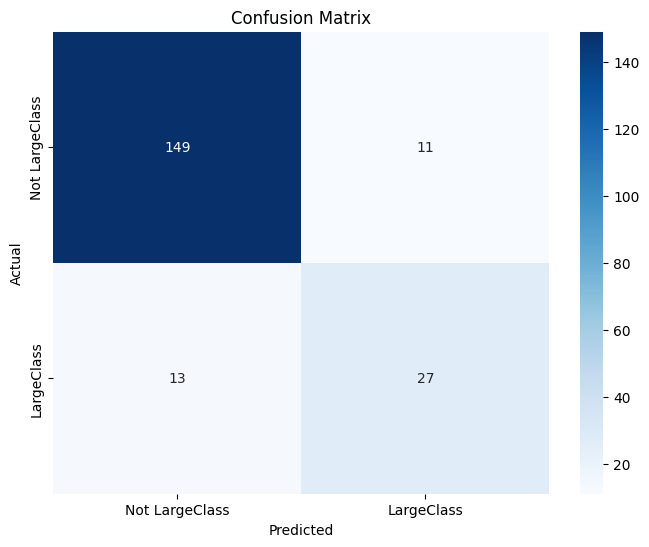

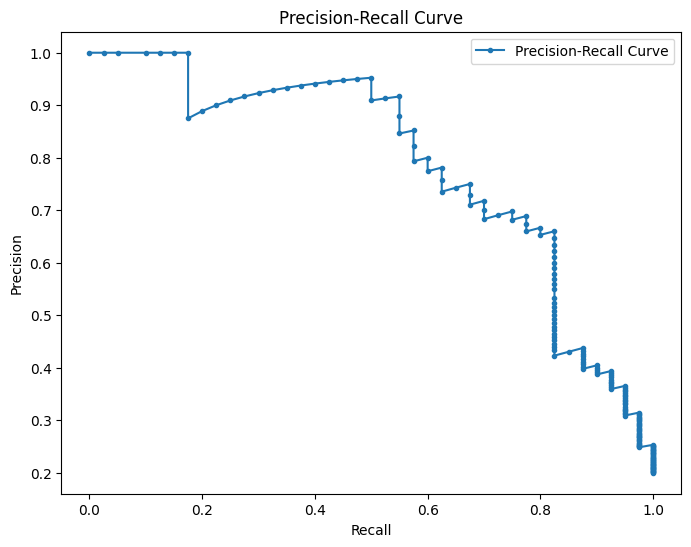

In [1]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define Relation-Aware BERT (RABERT) Model
class RelationAwareBERT(nn.Module):
    def __init__(self, pretrained_model='bert-base-uncased', relation_dim=16, num_labels=2):
        super(RelationAwareBERT, self).__init__()

        # BERT backbone
        self.bert = BertModel.from_pretrained(pretrained_model)

        # Relation embeddings
        self.relation_embedding = nn.Embedding(100, relation_dim)  # Assume max 100 unique relations

        # Classification head
        self.fc = nn.Linear(self.bert.config.hidden_size + relation_dim, num_labels)

    def forward(self, input_ids, attention_mask, relation_ids):
        # Standard BERT forward pass
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token representation

        # Incorporate relational embeddings
        relation_embeds = self.relation_embedding(relation_ids)  # Shape: (batch_size, relation_dim)
        cls_embedding = torch.cat([cls_embedding, relation_embeds], dim=1)  # Concatenate

        # Classification
        logits = self.fc(cls_embedding)
        return logits

# Custom Dataset Class
class RelationAwareDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, relation_map):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.relation_map = relation_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = row.drop('LargeClass').to_dict()
        text = ', '.join([f"{key}: {value}" for key, value in features.items()])
        label = row['LargeClass']

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Generate relation IDs (this is a placeholder; customize based on relationships in your data)
        relation_id = self.relation_map.get('default', 0)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'relation_ids': torch.tensor(relation_id, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load Dataset
data_path = 'lcd.csv'
data_df = pd.read_csv(data_path)

# Define relationships (customize as per dataset specifics)
relation_map = {
    'default': 0  # Placeholder for relation IDs
}

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Train-Test Split
train_data, test_data = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df['LargeClass'])
train_dataset = RelationAwareDataset(train_data, tokenizer, max_length=128, relation_map=relation_map)
test_dataset = RelationAwareDataset(test_data, tokenizer, max_length=128, relation_map=relation_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize Model
model = RelationAwareBERT(pretrained_model='bert-base-uncased', relation_dim=16, num_labels=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_model():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        relation_ids = batch['relation_ids'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask, relation_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation Function
def evaluate_model():
    model.eval()
    preds, true_labels, probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            relation_ids = batch['relation_ids'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask, relation_ids)
            probabilities = torch.softmax(logits, dim=1)[:, 1]

            probs.extend(probabilities.cpu().numpy())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Classification Report
    report = classification_report(true_labels, preds, target_names=['Not LargeClass', 'LargeClass'])
    print("\nClassification Report:\n", report)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not LargeClass', 'LargeClass'], yticklabels=['Not LargeClass', 'LargeClass'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Training Loop
for epoch in range(3):
    loss = train_model()
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

evaluate_model()
